## Notes
- **Missing data:** Streams with gaps are marked with a flag under ```f['alldata'][stream_name]['nogaps']```

In [1]:
import h5py
import os
import pandas as pd
import numpy as np
import uuid
import json

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import btrdb
from btrdb.utils.timez import *

In [2]:
path_to_data = os.path.join('../../../../../Volumes/NO NAME/sentinel')

In [3]:
fnames = ['bedford_2013-03-01_%s.h5'%(str(hr).zfill(2)) for hr in range(0,24)]
for fname in fnames:
    assert fname in os.listdir(path_to_data)
print('\n'.join(fnames))

bedford_2013-03-01_00.h5
bedford_2013-03-01_01.h5
bedford_2013-03-01_02.h5
bedford_2013-03-01_03.h5
bedford_2013-03-01_04.h5
bedford_2013-03-01_05.h5
bedford_2013-03-01_06.h5
bedford_2013-03-01_07.h5
bedford_2013-03-01_08.h5
bedford_2013-03-01_09.h5
bedford_2013-03-01_10.h5
bedford_2013-03-01_11.h5
bedford_2013-03-01_12.h5
bedford_2013-03-01_13.h5
bedford_2013-03-01_14.h5
bedford_2013-03-01_15.h5
bedford_2013-03-01_16.h5
bedford_2013-03-01_17.h5
bedford_2013-03-01_18.h5
bedford_2013-03-01_19.h5
bedford_2013-03-01_20.h5
bedford_2013-03-01_21.h5
bedford_2013-03-01_22.h5
bedford_2013-03-01_23.h5


In [4]:
laurels_api_key = '2301C47D67FB1C2C48D0CC7B'
db = btrdb.connect("api.ni4ai.org:4411", apikey=laurels_api_key)

# f = h5py.File(os.path.join(path_to_data, fnames[0]), 'r')

collection = 'lndunn/sentinel/bedford'
# annotations = {'latitude': np.average(f['alldata']['latitude']['raw']),
#               'longitude': np.average(f['alldata']['longitude']['raw'])}

tags = {'ac_voltage': {'name': 'voltage', 'unit': 'volts'},
        'freq': {'name': 'frequency', 'unit': 'Hz'},
        'neutral_current': {'name': 'neutral_current', 'unit': 'amps'},
        'sync_status': {'name': 'sync_stats', 'unit': 'mask'}
        }

uuids = dict(zip(tags.keys(), [uuid.uuid4() for key in tags.keys()]))


In [35]:
streams = db.streams_in_collection('lndunn')

In [45]:
collections = {}
for s in streams:
    coll = s.collection.split('/')
    if coll[0] not in collections.keys():
        collections[coll[0]] = {}
    
    if coll[1] not in collections[coll[0]].keys():
        collections[coll[0]][coll[1]] = {}
        
    if len(coll) >= 2:
        if coll[2] not in collections[coll[0]][coll[1]].keys():
            collections[coll[0]][coll[1]][coll[2]] = []

In [46]:
print(collections)

{'lndunn': {'events': {'switching_A': [], 'oscillations': [], 'switching_B': []}, 'brownout': {'whitesands': [], 'centex': [], 'conroe': []}, 'PQdata': {'underground': [], 'epri': []}}}


In [31]:
rmstream = db.stream_from_uuid('8c6b6e85-1a46-4db7-b8aa-21c81f1dd693')
rmstream.obliterate()

In [5]:
streams = db.streams_in_collection(collection)
names = [s.name for s in streams]
for key in tags.keys():
    if tags[key]['name'] not in names:
        s = db.create(uuid=uuids[key],
                      collection=collection,
                      tags=tags[key],
#                       annotations=json.dumps(annotations),
                 )



In [6]:
streams = ['ac_voltage','freq','sync_status']

def add_streams(fname):
    f = h5py.File(os.path.join(path_to_data, fname), 'r')
    print('ingesting', f)
    for s in streams:
        if not f['alldata'][s]['nogaps'][0]:
            # there's a flag for each stream in each 1-hr file indicating whether there are gaps
            # none of the data received so far has gaps
            # once we get more data, we'll need to figure out how they indicate where the gaps are
            print('data has gaps, skip for now')
            continue
            
        stream = db.stream_from_uuid(uuids[s])
        
        dt     = f['alldata'][s]['dt'][0]
        start  = f['alldata'][s]['tstart'][0]
        n_obs  = len(f['alldata'][s]['raw'])

        scale  = f['alldata'][s]['scale'][0]
        offset = f['alldata'][s]['offset'][0]
        
        time = (1e9*(dt*np.arange(0, n_obs) + start)).astype(int)
        meas = scale * pd.Series(f['alldata'][s]['raw']) + offset

        tnow = datetime.now()
        stream.insert(list(zip(time.tolist(), meas.tolist())))
        print('\t', 'finished ingesting %s'%(s))
        print('\t', str(datetime.now()-tnow).split('.')[0])

In [ ]:
add_streams(fnames[0])

ingesting <HDF5 file "bedford_2013-03-01_00.h5" (mode r)>


In [ ]:
def handler():    
    p = Pool(4)
    p.map(add_streams, fnames[1:])

# Explore file contents

In [7]:
f['alldata']['ac_voltage']['nogaps'][0]

1

In [10]:
# list of data streams
# for now just importing voltage, frequency, and status
# need to figure out whether neutral, etc are of interest
for key in f['alldata'].keys():
    if 'raw' in f['alldata'][key].keys():
        print (key)

ac_voltage
freq
latitude
longitude
neutral_current
neutral_to_ground
rms_record
sat_num
sync_status


In [16]:
print(ns_to_datetime(f['alldata']['ac_voltage']['tstart'][0]))
print(ns_to_datetime(1e9*f['alldata']['ac_voltage']['tstart'][0]))

1970-01-01 00:00:01.362096+00:00
2013-03-01 00:00:00+00:00


In [14]:
f['alldata']['neutral_current']['nogaps'][0]

1

In [26]:
*pd.Series(f['alldata']['neutral_current']['raw'][:10])+f['alldata']['neutral_current']['offset']

0   -0.136269
1   -0.133828
2   -0.131386
3   -0.131691
4   -0.128182
5   -0.119178
6   -0.114601
7   -0.122536
8   -0.133980
9   -0.131691
dtype: float32

In [15]:
sum(pd.Series(f['alldata']['neutral_current']['raw'])==0)

56088

In [19]:
8760*2*len(f['alldata']['neutral_current']['raw'])/1e9

3153.6

In [11]:
f['alldata']['ac_voltage'].keys()

<KeysViewHDF5 ['datumsize', 'datumtype', 'dt', 'fileinfo', 'fs', 'name', 'nogaps', 'offset', 'raw', 'scale', 'slength', 'sstart', 'successfulwrite', 'tlength', 'tstart', 'tunit', 'yunit']>

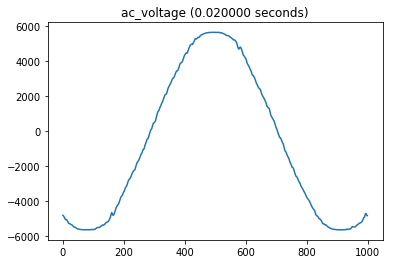

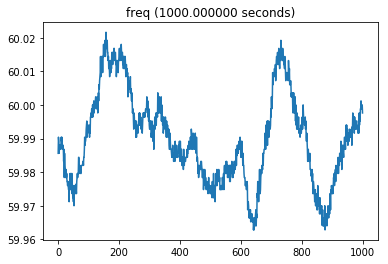

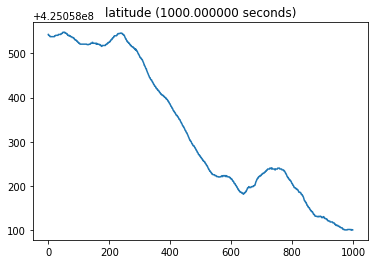

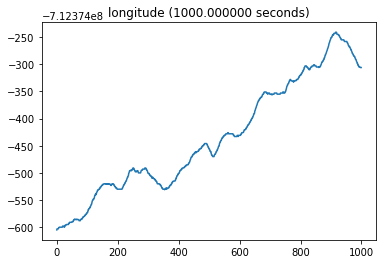

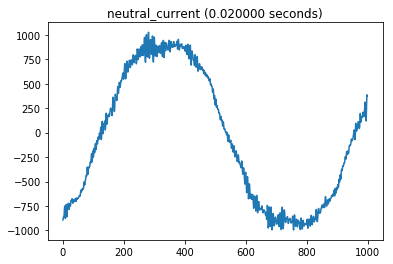

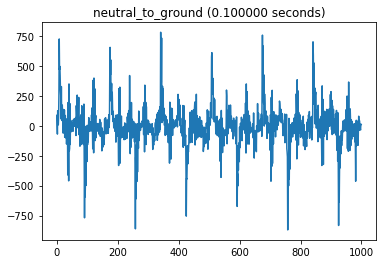

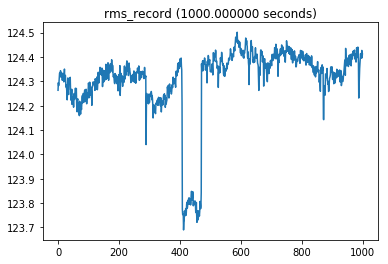

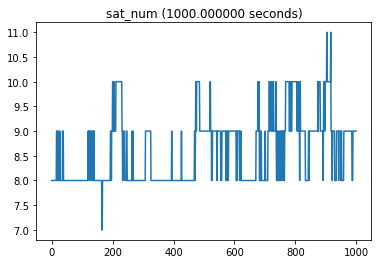

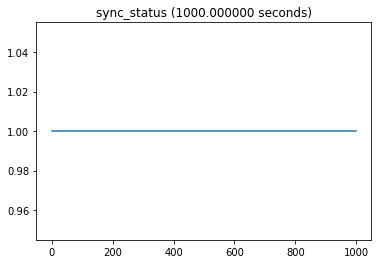

In [12]:
from matplotlib import pyplot as plt

for key in f['alldata'].keys():
    if 'raw' in f['alldata'][key].keys():
        n = 1000*f['alldata'][key]['dt'][0]
        scale = f['alldata'][key]['scale'][0]
        scale = f['alldata'][key]['scale'][0]
        
        fig, ax = plt.subplots()
        ax.plot(f['alldata'][key]['raw'][:1000])
        ax.set_title(key + ' (%f seconds)'%(n))
        plt.show()

In [41]:
for key in f['alldata']['freq'].keys():
    try:
        print(key, len(f['alldata']['freq'][key]))
    except:
        pass

datumsize 1
dt 1
fileinfo 1
fs 1
nogaps 1
offset 1
raw 3600
scale 1
slength 1
sstart 1
successfulwrite 1
tlength 1
tstart 1
